In [10]:
"""Simple Pickup Delivery Problem (PDP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

In [11]:
def get_manhattan_distance(xy1, xy2):
    dist = abs(xy1[0]-xy2[0]) + abs(xy1[1]-xy2[1])
    return dist

def get_distance_matrix(xy_tuple_list):
    full_list = []
    for point_1 in xy_tuple_list:
        row_list = []
        for point_2 in xy_tuple_list:
            dist = get_manhattan_distance(point_1, point_2)
            row_list.append(dist)
        full_list.append(row_list)
        
    return full_list


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['points'] =[
        (456, 320), # location 0 - the depot
        (228, 0),    # location 1
        (912, 0),    # location 2
        (0, 80),     # location 3
        (114, 80),   # location 4
        (570, 160),  # location 5
        (798, 160),  # location 6
        (342, 240),  # location 7
        (684, 240),  # location 8
        (570, 400),  # location 9
        (912, 400),  # location 10
        (114, 480),  # location 11
        (228, 480),  # location 12
        (342, 560),  # location 13
        (684, 560),  # location 14
        (0, 640),    # location 15
        (798, 640)   # location 16
    ]
    
    data["distance_matrix"] = get_distance_matrix(data["points"])
    
    data['pickups_deliveries'] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        [15, 11],
        #[13, 12],
        [16, 14],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    data['starts'] = [0, 0, 0, 13]
    data['ends'] = [0, 0, 0, 13]
    return data

In [12]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
    return plan_output

def get_solution_dict(data, manager, routing, solution):
    total_distance = 0
    solution_dict = {}
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_list = []
        while not routing.IsEnd(index):
            route_list.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            
        route_list.append(manager.IndexToNode(index))
        solution_dict[vehicle_id] = route_list
        total_distance += route_distance
    return solution_dict

In [13]:
"""Entry point of the program."""
# Instantiate the data problem.
data = create_data_model()

In [14]:
# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'],
                                       #data['depot'],
                                       data['starts'],data['ends']
                                      )

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Define cost of each arc.
def distance_callback(from_index, to_index):
    """Returns the manhattan distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    10000,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Define Transportation Requests.
for request in data['pickups_deliveries']:
    pickup_index = manager.NodeToIndex(request[0])
    delivery_index = manager.NodeToIndex(request[1])
    routing.AddPickupAndDelivery(pickup_index, delivery_index)
    routing.solver().Add(
        routing.VehicleVar(pickup_index) == routing.VehicleVar(
            delivery_index))
    routing.solver().Add(
        distance_dimension.CumulVar(pickup_index) <=
        distance_dimension.CumulVar(delivery_index))

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)
    #routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    plan_output = print_solution(data, manager, routing, solution)

Objective: 203180
Route for vehicle 0:
 0 ->  16 ->  14 -> 0
Distance of the route: 1324m

Route for vehicle 1:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Route for vehicle 2:
 0 ->  5 ->  2 ->  10 ->  9 -> 0
Distance of the route: 1712m

Route for vehicle 3:
 13 ->  12 ->  4 ->  3 ->  15 ->  11 -> 13
Distance of the route: 1964m

Total Distance of all routes: 6780m


In [15]:
routing

<ortools.constraint_solver.pywrapcp.RoutingModel; proxy of <Swig Object of type 'operations_research::RoutingModel *' at 0x7f8bb8213db0> >

In [16]:
get_solution_dict(data, manager, routing, solution)

{0: [0, 16, 14, 0],
 1: [0, 7, 1, 6, 8, 0],
 2: [0, 5, 2, 10, 9, 0],
 3: [13, 12, 4, 3, 15, 11, 13]}

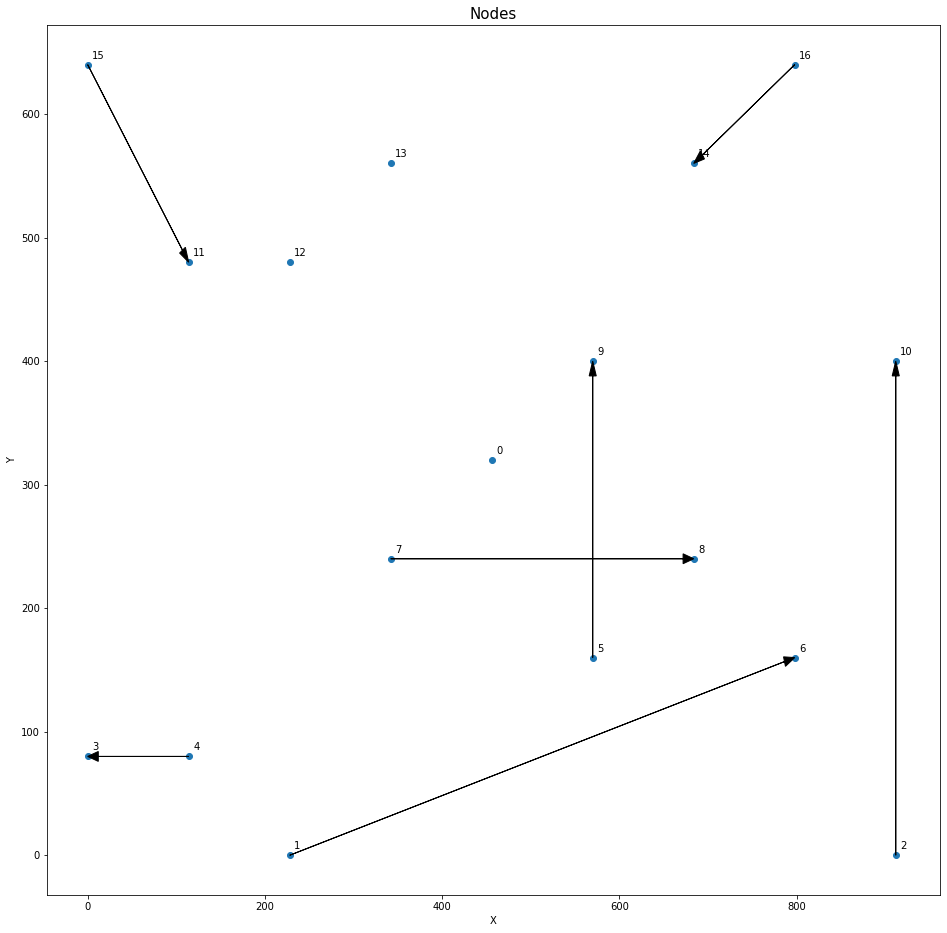

In [17]:
plt.figure(figsize=(16,16))
plt.scatter(*zip(*data["points"]))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Nodes",fontsize=15)

colors = ["r", "g", "b", "k"]

annotations = [str(i) for i in range(len(data["points"]))]
for i, label in enumerate(annotations):
    plt.annotate(label, (data["points"][i][0]+5, data["points"][i][1]+5))
    
for delivery in data["pickups_deliveries"]:

    p0 = data["points"][delivery[0]]
    p1 = data["points"][delivery[1]]
    plt.arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], head_width=8, length_includes_head=True, color="k")



plt.show()

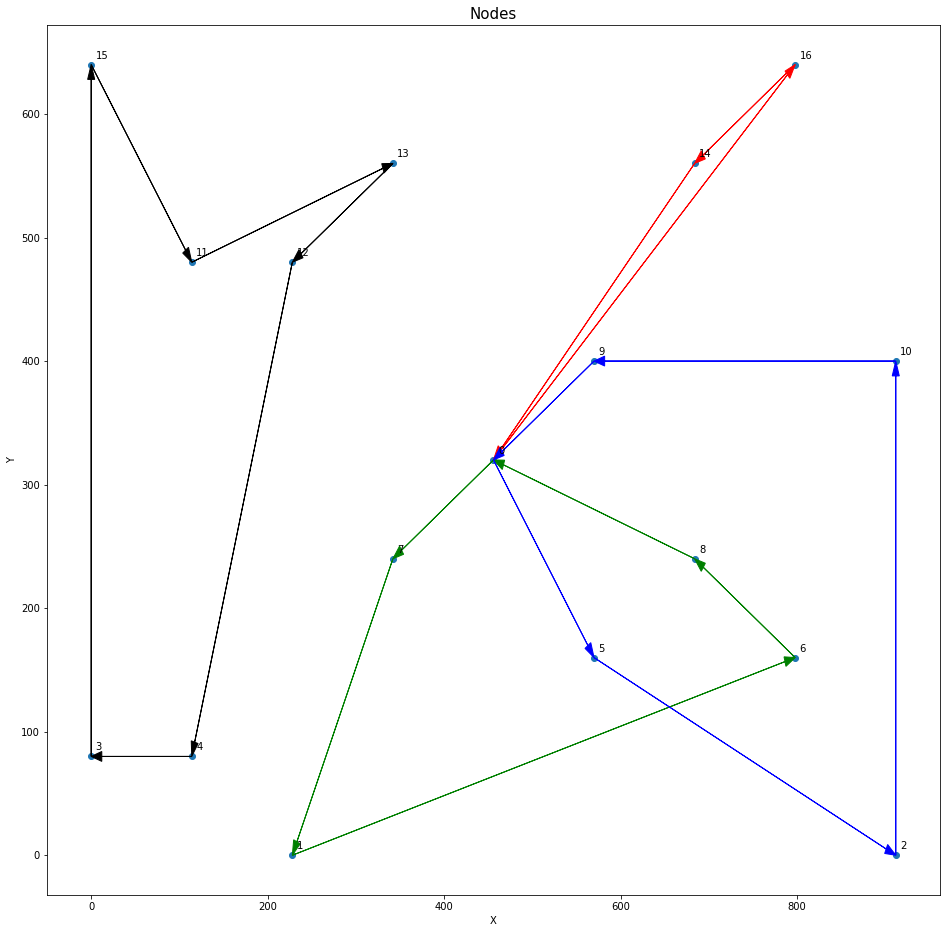

In [18]:
plt.figure(figsize=(16,16))
plt.scatter(*zip(*data["points"]))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Nodes",fontsize=15)

colors = ["r", "g", "b", "k", "r", "g", "b", "k"]

annotations = [str(i) for i in range(len(data["points"]))]
for i, label in enumerate(annotations):
    plt.annotate(label, (data["points"][i][0]+5, data["points"][i][1]+5))
    
solution_dict = get_solution_dict(data, manager, routing, solution)
for vehicle_id in range(data['num_vehicles']):
    color = colors[vehicle_id]
    path = solution_dict[vehicle_id]
    for i in range(len(path)-1):
        p0 = data["points"][path[i]]
        p1 = data["points"][path[i+1]]
        plt.arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], head_width=8, length_includes_head=True, color=color)



plt.show()